In [61]:
from datascience import *
import numpy as np
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

In [62]:
patients = Table.read_table('breast-cancer.csv').drop('ID')
patients.show(5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,1,1,1,2,1,3,1,1,0
5,4,4,5,7,10,3,2,1,0
3,1,1,1,2,2,3,1,1,0
6,8,8,1,3,4,3,7,1,0
4,1,1,3,2,1,3,1,1,0


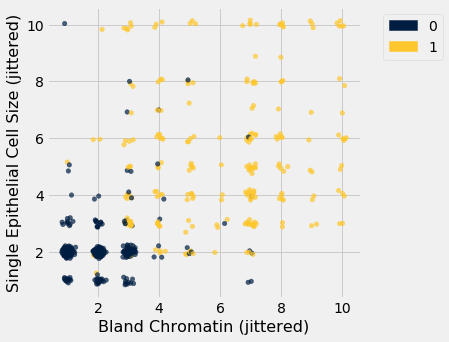

In [64]:
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))

jittered = Table().with_columns([
        'Bland Chromatin (jittered)', 
        randomize_column(patients.column('Bland Chromatin')),
        'Single Epithelial Cell Size (jittered)', 
        randomize_column(patients.column('Single Epithelial Cell Size')),
        'Class',
        patients.column('Class')
    ])

jittered.scatter(0, 1, colors='Class')

## Distance ##

In [65]:
def distance(pt1, pt2):
    """Return the distance between two points, represented as arrays"""
    return np.sqrt(sum((pt1 - pt2)**2))

def row_distance(row1, row2):
    """Return the distance between two numerical rows of a table"""
    return distance(np.array(row1), np.array(row2))

In [66]:
attributes = patients.drop('Class')
attributes.show(3)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
5,1,1,1,2,1,3,1,1
5,4,4,5,7,10,3,2,1
3,1,1,1,2,2,3,1,1


In [67]:
row_distance(attributes.row(0), attributes.row(1))

11.874342087037917

In [68]:
row_distance(attributes.row(0), attributes.row(2))

2.2360679774997898

In [69]:
row_distance(attributes.row(0), attributes.row(0))

0.0

## Classification Procedure ##

In [70]:
# Compute distance between example and every row in training. 
# Return training augmented with Distance column

def distances(training, example):
    """Compute distance between example and every row in training.
    Return training augmented with Distance column"""
    distances = make_array()
    attributes = training.drop('Class')
    for row in attributes.rows:
        distance = row_distance(row, example)
        distances = np.append(distances, distance)
    return training.with_column('Distance', distances)

In [71]:
patients.row(15)

Row(Clump Thickness=7, Uniformity of Cell Size=4, Uniformity of Cell Shape=6, Marginal Adhesion=4, Single Epithelial Cell Size=6, Bare Nuclei=1, Bland Chromatin=4, Normal Nucleoli=3, Mitoses=1, Class=1)

In [72]:
example = attributes.row(15)
example

Row(Clump Thickness=7, Uniformity of Cell Size=4, Uniformity of Cell Shape=6, Marginal Adhesion=4, Single Epithelial Cell Size=6, Bare Nuclei=1, Bland Chromatin=4, Normal Nucleoli=3, Mitoses=1)

In [73]:
distances(patients.exclude(15), example).sort('Distance')

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance
8,4,6,3,3,1,4,3,1,0,3.31662
5,3,4,1,4,1,3,1,1,0,5.19615
5,4,5,1,8,1,3,6,1,0,5.2915
8,2,4,1,5,1,5,4,4,1,5.47723
9,5,5,4,4,5,4,3,3,1,5.47723
6,3,3,3,3,2,6,1,1,0,5.47723
9,5,5,2,2,2,5,1,1,1,5.65685
3,4,5,3,7,3,4,6,1,0,5.65685
5,3,3,2,3,1,3,1,1,0,5.65685
5,6,5,6,10,1,3,1,1,1,5.83095


In [74]:
def closest(training, example, k):
    return distances(training, example).sort('Distance').take(np.arange(k))

In [75]:
closest(patients.exclude(15), example, 5).group('Class').sort('count', descending=True)

Class,count
0,3
1,2


In [76]:
def majority_class(topk):
    """Return the class with the highest count"""
    return topk.group('Class').sort('count', descending=True).column(0).item(0)

def classify(training, example, k):
    "Return the majority class among the k nearest neighbors of example"
    return majority_class(closest(training, example, k))

In [77]:
classify(patients.exclude(15), example, 5)

0

In [78]:
classify(patients.exclude(15), example, 7)

0

In [79]:
my_example = attributes.row(10)
my_example

Row(Clump Thickness=1, Uniformity of Cell Size=1, Uniformity of Cell Shape=1, Marginal Adhesion=1, Single Epithelial Cell Size=1, Bare Nuclei=1, Bland Chromatin=3, Normal Nucleoli=1, Mitoses=1)

In [80]:
classify(patients.exclude(10), my_example, 5)

0

In [81]:
patients.take(10)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
1,1,1,1,1,1,3,1,1,0


## Evaluation ##

In [83]:
patients.num_rows

683

In [86]:
shuffled = patients.sample(with_replacement=False)
training_set = shuffled.take(np.arange(341))
test_set = shuffled.take(np.arange(341, 683))

In [84]:
def evaluate_accuracy(training, test, k):
    """Return the proportion of correctly classified examples 
    in the test set"""
    test_attributes = test.drop('Class')
    num_correct = 0
    for i in np.arange(test_attributes.num_rows):
        c = classify(training, test_attributes.row(i), k)
        true_label = test.column('Class').item(i)
        num_correct = num_correct + (c == true_label)
    return num_correct / test.num_rows

In [87]:
evaluate_accuracy(training_set, test_set, 5)

0.9824561403508771

In [88]:
evaluate_accuracy(training_set, test_set, 7)

0.9707602339181286

In [89]:
evaluate_accuracy(training_set, test_set, 11)

0.9766081871345029

In [90]:
evaluate_accuracy(training_set, training_set, 1)

1.0